# Taller 4 - Representación y modelado

### Autores: [Ivan Meresman](https://ivanlmh.github.io/), [Daniel Herrera-Esposito](https://dherrera1911.github.io/)

## Ejercicio 1 - Representaciones para clasificación de células

En los cuadernos de práctico 4-1 y 4-2 se discutió la importancia de elegir una representación adecuada para el problema que quiero resolver, y cómo los resultados del aprendizaje pueden depender considerablemente de la representación usada.

En este ejercicio implementaremos un clasificador que indique el tipo de glóbulo blanco (GB) presente en imágenes de microscopía. El set de datos que usaremos tiene imágenes de microscopía, cada una con un glóbulo blanco. Hay diferentes tipos de glóbulo blanco (ej. Linfocitos, Neutrófilos), y el objetivo será clasificar las imágenes según el glóbulo blanco que muestran.

Para ello utilizaremos 3 representaciones bien distintas y compararemos los resultados obtenidos con cada una:

* 1) Una representación desarrollada a mano a partir de conocimiento del problema específico
* 2) Una representación de imágenes genérica que tiene invarianza a movimientos y rotación
* 3) Una representación lineal, que se obtiene combinando linealmente los valores de los píxeles. Esta se obtiene mediante PCA


Comenzamos importando los paquetes, y luego los datos (imágenes y las etiquetas) de internet

In [1]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import re # Biblioteca para realizar emparejamiento de expresiones regulares (hilos de caracteres)
import os
import sys
import skimage.io as imgio
import skimage as skim
from sklearn.model_selection import train_test_split

import numpy as np
import numpy.random as rng
import cv2 as cv

In [2]:
%%capture
!wget -O data.zip https://github.com/dherrera1911/talleres_aabc/raw/master/data/blood_images.zip
!unzip data.zip
!wget -qO etiquetas.csv https://raw.githubusercontent.com/dherrera1911/talleres_aabc/master/data/blood_labels.csv

Luego cargamos las imagenes y las etiquetas en variables. Imprimimos el tamaño del array que contiene las imágenes, y la tabla de datos con etiquetas.

In [3]:
# Cargar las etiquetas de las imagenes
etiquetas = pd.read_csv("etiquetas.csv")

# Cargar las imagenes
dir_img = 'blood_images'
image_names = sorted([os.path.join(dir_img, f) for f in os.listdir(dir_img) if os.path.isfile(os.path.join(dir_img, f))])
cellImages = np.empty((480, 640, 3, 0), dtype="uint8") #creamos un array vacío para ir llenando con imagenes
for i,fname in enumerate(image_names):
  tmpIm = plt.imread(fname)
  tmpIm = tmpIm.reshape(480, 640, 3, 1)
  cellImages = np.append(cellImages, tmpIm, axis=3)

# Obtenemos las etiquetas del problema
tiposCelulares = etiquetas['Category'].unique()

print(f"El array de datos que contiene las imágenes tiene dimensión {cellImages.shape}")
print(etiquetas)

El array de datos que contiene las imágenes tiene dimensión (480, 640, 3, 347)
     index  Unnamed: 0  Image    Category
0        0         NaN      0  NEUTROPHIL
1        1         NaN      1  NEUTROPHIL
2        2         NaN      2  NEUTROPHIL
3        3         NaN      3  NEUTROPHIL
4        4         NaN      4  NEUTROPHIL
..     ...         ...    ...         ...
342    405         NaN    405  NEUTROPHIL
343    407         NaN    407  NEUTROPHIL
344    408         NaN    408  NEUTROPHIL
345    409         NaN    409  NEUTROPHIL
346    410         NaN    410  EOSINOPHIL

[347 rows x 4 columns]


Del bloque de arriba vemos que el dataset cuenta con 347 imagenes a color (porque la 3ra dimensión vale 3, indicando que hay 3 canales de color), de 480x640 pixeles. También vemos que para cada imágen hay una categoría en `etiquetas`, como `NEUTROPHIL` y `EOSINOPHIL`.

A continuación, miramos las imágenes, mostrando 4 ejemplos para cada tipo de GB en el set de datos.


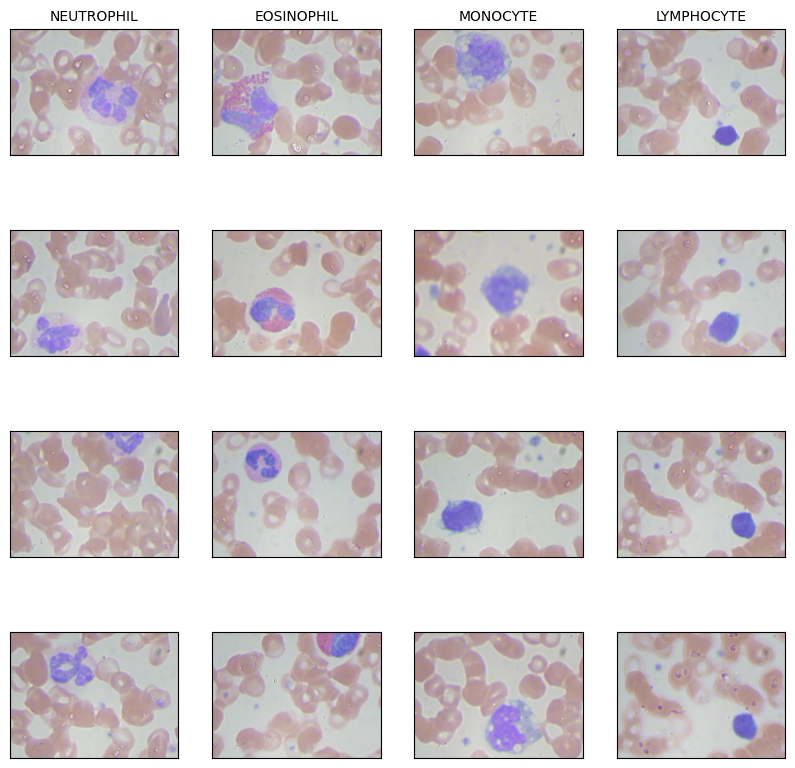

In [4]:
# Graficamos las imagenes, mostrando los 4 tipos de células
nPlot = 4
plt.figure(figsize=(10,10))
for t in range(len(tiposCelulares)):
    indicesCelula = np.where(etiquetas['Category'] == tiposCelulares[t])[0]
    imagenesTipo = cellImages[:,:,:,indicesCelula[0:nPlot]]
    for im in range(nPlot):
        plt.subplot(nPlot, len(tiposCelulares), t+1+im*len(tiposCelulares))
        if im==0:
            plt.title(tiposCelulares[t], fontdict={'fontsize': 10})
        plt.imshow(imagenesTipo[:,:,:,im])
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
plt.show()

Vemos arriba que el dataset consiste de imágenes de microscopía. Los colorantes usados en la
técnica le dan distinto color a las distintas células. Los glóbulos rojos no absorben el colorante
azul, pero los glóbulos blancos sí. En particular, es el núcleo de los glóbulos blancos que
absorve el color azul.

La principal manera de distinguir glóbulos blancos es mirando su núcleo. A continuación
haremos un procesamiento de imágenes para extraer la imágen del núcleo y eliminar el
fondo. Para ello, primero miramos los tres canales de color de las imágenes
RGB (red, green, blue).

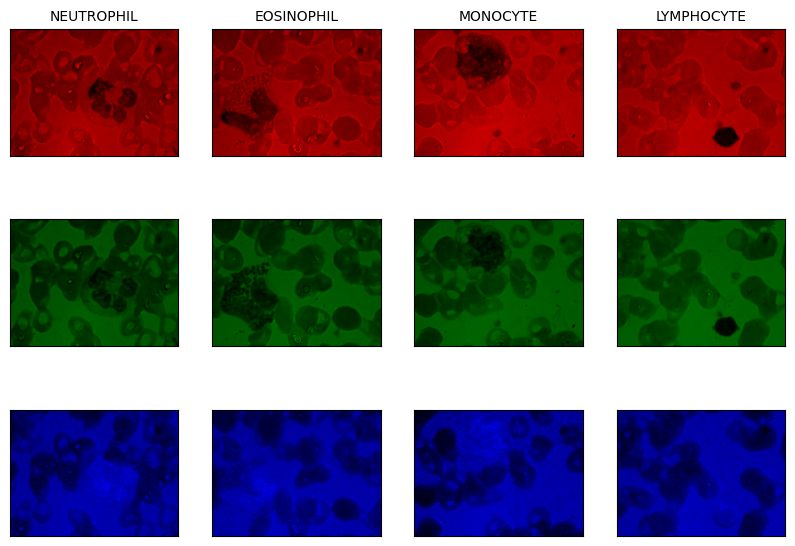

In [5]:
from matplotlib.colors import LinearSegmentedColormap
# creamos mapas de color rojo, verde y azul
rojos  = LinearSegmentedColormap.from_list(name="rojos",colors=["black","red"])
verdes = LinearSegmentedColormap.from_list(name="rojos",colors=["black","green"])
azules = LinearSegmentedColormap.from_list(name="rojos",colors=["black","blue"])
mapasColores = [rojos, verdes, azules]

# mostramos una imagen de cada tipo con las 3 escalas de color
plt.figure(figsize=(10, 7))
for t in range(len(tiposCelulares)):
    indicesCelula = np.where(etiquetas['Category'] == tiposCelulares[t])[0]
    imagenesTipo = cellImages[:,:,:,indicesCelula[0]]
    for ch in range(3):
        plt.subplot(3, len(tiposCelulares), t+1+ch*len(tiposCelulares))
        if ch==0:
            plt.title(tiposCelulares[t], fontdict={'fontsize': 10})
        plt.imshow(imagenesTipo[:,:,ch], cmap=mapasColores[ch])
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
plt.show()

Vemos que el núcleo de los GB presenta poco rojos, mucho azul. Para simplificar,
generamos una imagen en escala de grises tomando el canal azul, y restándole el canal rojo.
Así los núcleos se verán más claros que el fondo más oscuro.

Ahora la forma del array de imagenes es: (480, 640, 347)
Notamos que ya no tenemos la dimensión del canal de color, sino que ahora el array tiene 3 dimensiones: alto, ancho y el numero de imagen


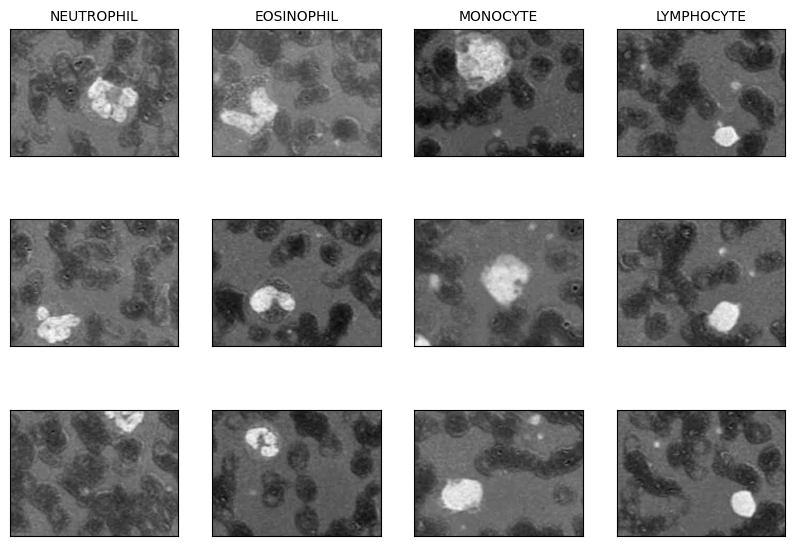

In [6]:
# las imagenes por default se codifican de una forma que solo admite valores entre 0-255. Cambiamos eso para hacer la resta
cellImages = cellImages.astype("int32")
# tomamos el canal azul (2) y le restamos el canal rojo (0)
imagenes1 = cellImages[:,:,2,:] - cellImages[:,:,0,:]
# le restamos el valor mínimo para llevar a 0 el valor mínimo, y recodificamos en el formato de las imagenes, uint8
imagenes1 = imagenes1 - np.min(imagenes1)
imagenes1 = imagenes1.astype("uint8")

print(f"Ahora la forma del array de imagenes es: {imagenes1.shape}")
print("Notamos que ya no tenemos la dimensión del canal de color, sino que ahora el array tiene 3 dimensiones: alto, ancho y el numero de imagen")

# graficamos 3 imagenes de cada tipo en la escala de grises
nPlot = 3
plt.figure(figsize=(10,7))
for t in range(len(tiposCelulares)):
    indicesCelula = np.where(etiquetas['Category'] == tiposCelulares[t])[0]
    imagenesTipo = imagenes1[:,:,indicesCelula[0:nPlot]]
    for im in range(nPlot):
        plt.subplot(nPlot, len(tiposCelulares), t+1+im*len(tiposCelulares))
        if im==0:
            plt.title(tiposCelulares[t], fontdict={'fontsize': 10})
        plt.imshow(imagenesTipo[:,:,im], cmap='gray')
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
plt.show()

En las imágenes de arriba se ve que el núcleo de los GB se distingue por su intesidad.

Como último paso para simplificar aún más el problema aplicamos un umbral para hacer binarias
las imágenes, y que sólo estén activos los píxeles del núcleo. Esto ayudará a generar la
representación manual.

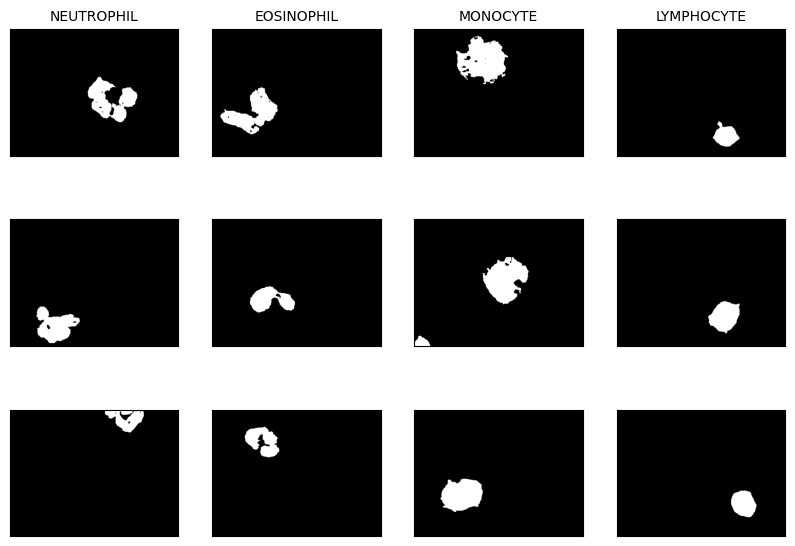

In [7]:
from scipy import ndimage as ndi

# aplicamos un umbral a las imagenes, obteniendo imagenes binarias
imagenesBin = (imagenes1 > 130)

# luego aplicamos un poco de procesamiento para eliminar los núcleos de las plaquetas
for im in range(imagenesBin.shape[2]):
  label_objects, nb_labels = ndi.label(imagenesBin[:,:,im])
  sizes = np.bincount(label_objects.ravel())
  mask_sizes = sizes > 1000
  mask_sizes[0] = 0
  imagenesBin[:,:,im] = mask_sizes[label_objects]

# mostramos algunas imagenes binarizadas
nPlot = 3
plt.figure(figsize=(10,7))
for t in range(len(tiposCelulares)):
    indicesCelula = np.where(etiquetas['Category'] == tiposCelulares[t])[0]
    imagenesTipo = imagenesBin[:,:,indicesCelula[0:nPlot]]
    for im in range(nPlot):
        plt.subplot(nPlot, len(tiposCelulares), t+1+im*len(tiposCelulares))
        if im==0:
            plt.title(tiposCelulares[t], fontdict={'fontsize': 10})
        plt.imshow(imagenesTipo[:,:,im], cmap='gray')
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
plt.show()

Vemos arriba que conseguimos nuevas imágenes que indican claramente el núcleo del GB, y donde nos deshicimos de todo lo que lo rodea. En este proceso hicimos un cambio de representación importante, en el que descartamos mucha información de las imagenes, pero nos quedamos con un tipo de información específica: los píxeles que pertenecen al núcleo de los GB.

### Representación manual

Los diferentes tipos de GB tienen núcleos celulares con formas, estructuras y tamaños diferentes. Esta es
una de las principales formas de identificar visualmente los tipos de GB, según las características
de su núcleo. En esta [guía de histología](https://www.histology.leeds.ac.uk/blood/blood_wbc.php), por ejemplo, se
señala que se puede identificar a los GB según cuantos lóbulos tiene su núcleo, el tamaño del mismo,
y según la presencia de gránulos, que pueden verse como 'agujeros' en el núcleo.

Para construir nuestra primera representación del problema, usamos este conocimiento experto. En el bloque
de código de abajo usamos herramientas estándar del paquete de procesamiento de imágenes `ndimage` de
`scipy` para contar aproximadamente el **número de lóbulos** y el **número de agujeros** presentes en
la 'mancha blanca' de cada imagen. Luego con Python base medimos el **ancho y el alto del núcleo**.
Al final, separamos en sets de testeo y entrenamiento, e imprimimos la tabla de entrenamiento resultante.

**Ejercicio 1.1:** En el código de abajo dejamos una línea vacía para que usted calcule el **área del núcleo** en la imágen. Le sugerimos que lo haga sumando los píxeles de la imagen, que valen 1 si pertenecen al núcleo, y 0 en caso contrario. Puede usar la función *np.sum()*.

**Nota:** Note que las representaciones de arriba son aproximadamente **invariantes** a la rotación o el desplazmiento de la imagen (ej. estas transformaciones no afectan el área del núcleo)

In [10]:
# contar fragmentos
lobulos = []
agujeros = []
altura = []
ancho = []
area = []
for im in range(imagenesBin.shape[2]):
    
  # extraemos la imagen para anlizar
  imagenTemp = imagenesBin[:,:,im]
    
  # usamos erosion para cortar las uniones entre los lóbulos, y contar cuantas manchas sueltas quedan
  erodedIm = ndi.binary_erosion(imagenTemp, iterations=12)
  label_objects, nb_labels = ndi.label(erodedIm)
  lobulos.append(np.unique(nb_labels)[0])
    
  # tomamos el negativo de la imagen y contamos cuantas manchas hay, que son los "agujeros" en el núcleo
  negativeIm = 1 - imagenTemp
  label_objects, nb_labels = ndi.label(negativeIm)
  agujeros.append(np.unique(nb_labels)[0]-1)
    
  # medimos las coordenadas del objeto para tener tamaño
  sumaVert = np.sum(imagenTemp, axis=0)
  indicesVert = sumaVert.nonzero()[0]
  altura.append(indicesVert[len(indicesVert)-1] - indicesVert[0])
    
  sumaHor = np.sum(imagenTemp, axis=1)
  indicesHor = sumaHor.nonzero()[0]
  ancho.append(indicesHor[len(indicesHor)-1] - indicesHor[0])
    
  # contamos los pixeles para tener el area del nucleo
  areaTotal = np.sum() ### LLENAR LINEA
  area.append(areaTotal)


TypeError: sum() missing 1 required positional argument: 'a'

In [11]:
# Juntamos los datos recolectados en un pandas dataframe
representacionManual = pd.DataFrame(list(zip(lobulos, agujeros, altura, ancho, area)),
                                    columns=['Lobulos', 'Agujeros', 'Alto', 'Ancho', 'Area'])

# dividimos los datos en entrenamiento y testeo
Xtrain_man, Xtest_man, ytrain_man, ytest_man = train_test_split(representacionManual, etiquetas['Category'],
                                                test_size=0.33, stratify=etiquetas['Category'], random_state=42)

# Estas 2 líneas son para resetear el índice de las filas. Es un detalle no importante
Xtrain_man.reset_index(inplace=True, drop=True)
Xtest_man.reset_index(inplace=True, drop=True)

print(Xtrain_man)
print(ytrain_man)

ValueError: Found input variables with inconsistent numbers of samples: [0, 347]

### Representacion genérica de imágenes

Aunque en este problema particular hay algunas características útiles que podemos extraer de las imágenes de forma simple, este no siempre es el caso. Sin embargo, para algunos problemas comunes como la clasificación de imágenes, hay un repertorio de representaciones genéricas que suelen ser útiles.

Un ejemplo de esto es la representación mediante **local binary patterns** (LBP, [explicación aquí](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html)). En esta técnica, se analiza el patrón de vecinos alrededor de cada pixel de una imagen, y se le asigna a este grupo de píxeles un número que describe el patrón local de píxeles. Los detalles no importan mucho, pero estos diferentes patrones pueden representar por ejemplo líneas, bordes, áreas homogéneas, vértices, etc. Luego de que se asignó un patrón a cada pixel, contamos cuantas veces ocurre cada patrón, y lo ponemos en un vector.

Este vector representa, de cierta forma, la *textura* de la imagen. También **tiene cierta invarianza**, porque al sumar las ocurrencias de cada patrón, genera el mismo resultado ante traslaciones de la imagen. Según la forma en que se computen los LBP, estos pueden ser invariantes a rotación también (abajo usamos un método invariante a rotación).

En el bloque de código de abajo obtenemos la representación de LBP para cada imagen, donde cada columna indica la cantidad de veces que ocurre el LBP correspondiente. Luego lo separamos en set de testeo y entrenamiento, e imprimimos el set de entrenamiento.

In [12]:
from skimage.feature import local_binary_pattern

radio = 3 # parámetro modificable
n_puntos = 8*radio #parámetro modificable
nbins = n_puntos+1 # número de patrones posibles
# generamos los nombres de las columnas
numeroCols = np.arange(nbins).tolist()
nombresCols = ['LBP'+str(num+1) for num in numeroCols]

# generamos un dataframe vacío para ir llenando con los datos
representacionGenerica = pd.DataFrame([], columns=nombresCols)

for im in range(imagenesBin.shape[2]):
  # computamos el patrón de cada pixel
  lbp = local_binary_pattern(imagenesBin[:,:,im], P=n_puntos, R=radio, method='uniform')
    
  # extraemos la cantidad de ocurrencias de cada patrón
  histograma, bin_edges = np.histogram(lbp, bins=nbins)
    
  # agregamos el histograma de esta imagen como una neuva fila en el dataframe
  histograma = histograma.tolist()
  df_len = len(representacionGenerica)
  representacionGenerica.loc[df_len] = histograma


## Representación lineal, PCA

Finalmente, usamos otra representación de las imágenes, que obtenemos mediante PCA. Como ya vimos en clases pasadas, cuando aplicamos PCA a un conjunto de variables, la técnica nos devuelve las combinaciones lineales de estas variables que explican más variabilidad en los datos. En este caso aplicamos PCA directamente sobre los píxeles de las imágenes, entonces cada componente principal es una combinación lineal de píxeles. Es decir, cada componente principal es una suma de los píxeles de la imagen, cada pixel pesado por un coeficiente específico al componente principal.

A diferencia de las dos representaciones anteriores, esta representación **no es necesariamente invariante** a traslaciones y rotaciones.

En el bloque de código de abajo separamos el dataset en testeo y entrenamiento, les aplicamos PCA, y luego imprimimos los datos del set de entrenamiento.

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

componentes = 25 # parametro modificable
numeroCols = np.arange(componentes).tolist()
nombresCols = ['PC'+str(num+1) for num in numeroCols]

# Alargamos las imagenes, para que quede una columna por cada pixel
imagenesAlargadas = np.transpose(np.reshape(imagenesBin, (480*640, imagenesBin.shape[2])))

# Separamos las imagenes alargadas en entrenamiento y testeo
imagenesTrain, imagenesTest, ytrain_lin, ytest_lin = train_test_split(imagenesAlargadas, etiquetas['Category'],
                                                test_size=0.33, stratify=etiquetas['Category'], random_state=42)

# Estandarizamos los datos
preproc = StandardScaler() # aquí generamos preproc que es una función para estandarizar datos
preproc.fit(imagenesTrain) # aquí extraemos los parámetros de Xscore para estandarizar (media, sd)
imagenesTrain = pd.DataFrame(preproc.transform(imagenesTrain))
imagenesTest = pd.DataFrame(preproc.transform(imagenesTest))

# Ajustamos un PCA a los datos de entrenamiento
modeloPCA = PCA(n_components=componentes)
modeloPCA.fit(imagenesTrain)

# Obtenemos el valor de los PC para el entrenamiento y el testeo
Xtrain_lin = pd.DataFrame(modeloPCA.transform(imagenesTrain))
Xtest_lin = pd.DataFrame(modeloPCA.transform(imagenesTest))

# Le ponemos nombre a las columnas
Xtrain_lin.columns = nombresCols
Xtest_lin.columns = nombresCols

Xtrain_lin.reset_index(inplace=True, drop=True)
Xtest_lin.reset_index(inplace=True, drop=True)

print(Xtrain_lin)


            PC1         PC2        PC3         PC4         PC5         PC6  \
0     18.569210 -123.449136   2.397094  -42.840527  -24.421745  126.187645   
1    -84.419032  103.454068  21.743194 -135.880941   69.796147   65.440544   
2   -118.077231  135.914073   3.071920 -148.898266   33.336774   34.359629   
3    -27.593002  -88.744329  98.771172   85.802619  -93.699912  222.480858   
4     27.771557 -161.018028 -29.903144  -67.859333  -16.174019   13.739501   
..          ...         ...        ...         ...         ...         ...   
227  115.661785   11.967032  -3.652016   -7.061088   93.638211  -18.537062   
228 -123.587779  128.081900 -29.382518 -102.609385  -27.777858  -33.428698   
229  -92.796523    7.383490  83.712516   -4.822829  -60.585860 -108.410180   
230  -23.340592  -84.299935 -47.954535  -18.727906  -86.041872 -150.953535   
231   85.757644  -96.710093 -43.705521  -63.626291  101.830711    2.680831   

            PC7         PC8        PC9        PC10  ...       P

Notemos que ahora contamos con 3 representaciones distintas de las mismas imágenes: una elegida a mano, basada en conocimiento experto; otra genérica para imágenes que representa la distribución de patrones; y los componentes principales, que son combinaciones lineales de los píxeles crudos. A continuación, utilizaremos cada una de las representaciones para ajustar un modelo de regresión logística regularizado que clasifique las imágenes.

 **Ejercicio 1.2:** No es a priori obvio cual de las representaciones puede tener el mejor rendimiento. Sin embargo, piense cual cree usted que tendrá el mejor rendimiento y explique su razonamiento.

*Puede insertar su respuesta aquí*

**Ejercicio 1.3:** En el siguiente bloque de código ajustamos la regresión logística y vemos el desempeño de cada representación. Se dejaron algunas líneas vacías para que usted complete.

In [44]:
from sklearn.linear_model import RidgeClassifier

alpha = 1 # parametro modificable

# Ajustamos y testeamos el modelo con la representacion manual
ridgeManual = RidgeClassifier(alpha=alpha)
ridgeManual.fit()                 # PARA RELLENAR
scoreManual = ridgeManual.score() # PARA RELLENAR

# Ajustamos y testeamos el modelo con la representacion generica
ridgeGenerica = RidgeClassifier(alpha=alpha)
ridgeGenerica.fit()                   # PARA RELLENAR
scoreGenerica = ridgeGenerica.score() # PARA RELLENAR

# Ajustamos y testeamos el modelo con la representacion lineal
ridgeLineal = RidgeClassifier(alpha=alpha)
ridgeLineal.fit()                 # PARA RELLENAR
scoreLineal = ridgeLineal.score() # PARA RELLENAR
print(f"Rendimientos: representacion manual ({scoreManual*100:.1f}%), representacion generica ({scoreGenerica*100:.1f}%), representacion lineal ({scoreLineal*100:.1f}%)")


Rendimientos: representacion manual (58.3%), representacion generica (53.0%), representacion lineal (57.4%)


**Ejercicio 1.4:** ¿Cómo se comparan los resultados con su hipótesis de arriba? Discuta brevemente las posibles discrepancias.

*Puede insertar su respuesta aquí*

**Ejercicio 1.5:** Aunque arriba comparamos las 3 representaciones distintas, a veces diferentes representaciones de un problema son complementarias y podemos mejorar el rendimiento mezclándolas. En el bloque de código de abajo combine un par de representaciones (o más) y mida el rendimiento del modelo resultante. Discuta sus resultados.

**Nota:** Lo que tiene que hacer es pegar dos dataframes, de forma que quede uno más grande con más columnas y la misma cantidad de filas. Se pone el ejemplo de cómo hacerlo para los datos de entrenamiento, pero debe replicarlo para los datos de testeo.

In [45]:
# Unimos dos datasets de entrenamiento. Las filas están en el mismo orden, porque usamos
# el mismo seed para el train-test split para cada caso, asique sólo hay que pegar las columnas

# RELLENE: Ponga los datos que quiere concatenar en las listas de abajo
lista_entrenamiento_concatenar = []# Rellene
lista_testeo_concatenar = [] # Rellene

Xtrain_cat = pd.concat(lista_entrenamiento_concatenar, axis=1, join='inner', ignore_index=True)
Xtest_cat = pd.concat(lista_testeo_concatenar, axis=1, join='inner', ignore_index=True)

ridgeCat = RidgeClassifier(alpha=1)
ridgeCat.fit(X=Xtrain_cat, y=ytrain_lin)
scoreCat = ridgeCat.score(Xtest_cat, ytest_lin)

print(f"El rendimiento del modelo que eligió es {scoreCat*100:.1f}%")

El rendimiento del modelo que eligió es 53.0%


*Introduzca su respuesta aquí*

**Ejercicio 1.6:** En el análisis hasta ahora, usamos más de un hiperparámetro en diferentes pasos. Por ejemplo, la distancia y la cantidad de vecinos en el LBP, la cantidad de componentes en el PCA, y el valor del término de regularización (alpha) en el modelo de Ridge. ¿Piensa que pueden cambiar los resultados cambiando estos parámetros? Ponga a prueba y discuta

*Inserte su respuesta aquí*

**Extra 1.1:** En todo lo realizado anteriormente, comparamos las diferentes representaciones usando un clasificador lineal con regularización Ridge. ¿Piensa que pueden cambiar los resultados si usamos otro tipo de clasificador? Ponga a prueba entrenando otro clasificador (por ejemplo, árbol de decisión o K vecinos más cercanos) con las diferentes representaciones. Discuta sus resultados.

**Nota:** Si usa KNN recuerde normalizar las variables. Para el árbol de decisión no es necesario. Vea que para la regresión lineal activamos la opción *normalize=True*, que no está disponible en KNeighborsClassifier

In [46]:
# Si hace el ejercicio Extra 1.1 puede hacerlo en este bloque de código
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Ejercicio 2 - Análisis de texto para clasificar opiniones de películas

Las imágenes, como las que vimos en el ejercicio anterior, son un tipo de dato muy analizado en aprendizaje automático. Otro de los principales tipos de datos analizados es el lenguaje natural, o el texto escrito. En este ejercicio veremos una de las representaciones más básicas para trabajar con texto, la representación de **bag-of-words**.

Utilizaremos una base de datos que tiene miles de críticas de películas extraídos de IMDB, cada uno clasificado como crítica positiva o negativa. Los datos son extraídos de [este link](http://ai.stanford.edu/~amaas/data/sentiment/), y el análisis es casi el mismo que está presentado en el capítulo 7 del Muller \& Guido.


Comenzamos importando los datos de internet y descomprimiéndolos.

In [20]:
%%capture
!mkdir -p data_texto
!wget -O data_texto.zip https://github.com/dherrera1911/talleres_aabc/raw/master/data/data_texto.zip
!unzip -o -d data_texto data_texto.zip

Luego cargamos las críticas a `text_train`, y las etiquetas que dicen si la crítica es positiva o negativa a `y_train` 

In [35]:
from sklearn.datasets import load_files

reviews_train = load_files("data_texto/aclImdb/train/")
# load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target

Luego imprimimos algunas características de los datos, incluyendo la segunda crítica del dataset.

In [41]:
print("Clase de variable que es text_train: {}".format(type(text_train)))
print("Cantidad de documentos en text_train: {}".format(len(text_train)))
print("Documentos por clase (train): {}".format(np.bincount(y_train)))
print("\n Segundo documento en text_train:\n\n{}".format(text_train[1]))

Clase de variable que es text_train: <class 'list'>
Cantidad de documentos en text_train: 25000
Documentos por clase (train): [12500 12500]

 Segundo documento en text_train:

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the b

**Ejercicio 2.1:** ¿Es la crítica impresa arriba positiva o negativa? Intente describir qué características de la misma piensa que podría usar un algoritmo para clasificarla. En lo posible, responda este ejercicio antes de seguir avanzando.

*Inserte su respuesta aquí*

Imprimimos la etiqueta de la crítica mostrada arriba, donde 0=Negativo, y 1=Positivo.

In [42]:
print(f"La crítica de arriba es {y_train[1]}")

La crítica de arriba es 0


A continuación importamos también los datos de testeo, y eliminamos algunos caracteres de formateo que pueden tener los datos.

In [43]:
reviews_test = load_files("data_texto/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print("Cantidad de documentos en set de testeo: {}".format(len(text_test)))
print("Documentos por clase (test): {}".format(np.bincount(y_test)))

# eliminamos algunos caracteres de formateo
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

Cantidad de documentos en set de testeo: 25000
Documentos por clase (test): [12500 12500]


Ahora con los datos cargados, los convertiremos a una representación con la que es más fácil trabajar, la representación de **bag-of-words**. En esta representación, lo que tenemos es simplemente una indicación de qué palabras tenemos en el texto, y cuantas veces ocurre cada una. La representación se llama bag-of-words porque sólo nos quedamos con esa lista de palabras, y perdemos toda la demás estructura del texto (ej. las relaciones gramáticas entre las palabras, su orden en el texto, etc).

Lo primero que se hace para armar la representación es tomar cada secuencia de caracteres que tenemos y separarla en palabras (*tokenizar*).

Luego, nos fijamos en nuestros datos todas las palabras que tenemos, y con eso construimos un *diccionario* o *vocabulario* de las palabras posibles para nuestros datos. Este vocabulario tendrá un determinado orden, y cada palabra tiene su índice que la caracteriza.

Finalmente, para cada documento (que ahora es una lista de palabras) armamos un vector con el mismo largo que nuestro diccionario, donde cada entrada del vector indica con un número cuantas veces ocurre la palabra correspondiente a ese índice. De esa forma, cada archivo de texto lo representamos como un vector que indica cuantas veces ocurre cada palabra del diccionario, sin mantener las relaciones entre las mismas, lo que es la representación **bag-of-words**.

El proceso descrito arriba se ilustra en la imagen de abajo (Figura 7-1 del Muller \& Guido).



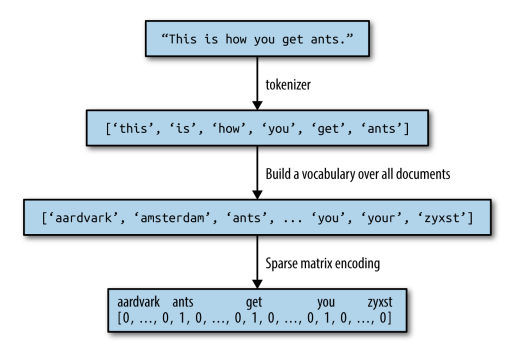

El paquete sklearn cuenta con una función llamada *CountVectorizer* que recibe una lista de documentos de texto y arma el diccionaro con las mismas. Luego podemos usar el diccionario creado para transformar listas de documentos a la representación bag-of-words.

En el bloque de código de abajo utilizamos CountVectorizer para convertir las críticas de películas al formato bag-of-words.

**Ejercicio 2.2:** Note el parámetro `min_df=5` en el llamado a CountVectorizer. Este parámetro hace que en el diccionario generado sólo se incluyan palabras que aparecen en al menos 5 documentos en la base de datos. ¿Porqué cree que puede ser deseable eliminar las palabras que aparecen en menos de 5 documentos? (esto se discute en el libro, puede buscar allí, o especular)

*Inserte su respuesta aquí*

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

A continuación imprimimos los primeros 1000 elementos del vector que representa al primer documento de texto. Como el mismo está guardado en formato *sparse matrix*, esto sólo nos devuelve un indicador de cuales elementos son distintos de 0.

In [45]:
print("X_train with min_df: {}".format(repr(X_train)))
print(X_train[0,0:1000])

X_train with min_df: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>
  (0, 518)	1
  (0, 527)	1
  (0, 969)	1


**Ejercicio 2.3:** En el bloque de código anterior se ve que de los primeros mil elementos del vector del primer documento de texto, sólo 3 son diferentes que 0. ¿Qué significa esto, con respecto a la proporción de palabras de nustro diccionario que se encuentran en el documento?

*Inserte su respuesta aquí*

Para ilustrar, abajo extraemos las palabras del diccionario que generamos, con la función *get_feature_names*. Luego, imprimimos algunas de las palabras del diccionario

In [46]:
nombres_palabras = vect.get_feature_names_out()
print("Primeras 20 entradas del diccionario:\n{}".format(nombres_palabras[:20]))
print("Entradas 20010 a 20030 del diccionario:\n{}".format(nombres_palabras[20010:20030]))
print("Entradas 1, 1001, 2001, etc:\n{}".format(nombres_palabras[::1000]))

Primeras 20 entradas del diccionario:
['00' '000' '007' '00s' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10'
 '100' '1000' '100th' '101' '102' '103']
Entradas 20010 a 20030 del diccionario:
['repentance' 'repercussions' 'repertoire' 'repetition' 'repetitions'
 'repetitious' 'repetitive' 'rephrase' 'replace' 'replaced' 'replacement'
 'replaces' 'replacing' 'replay' 'replayable' 'replayed' 'replaying'
 'replays' 'replete' 'replica']
Entradas 1, 1001, 2001, etc:
['00' 'alternatively' 'baked' 'bothersome' 'centipede' 'complicity'
 'cutlery' 'disgraceful' 'elton' 'fatal' 'gaining' 'hamburgers' 'ideals'
 'ivory' 'leering' 'martin' 'moxy' 'opportunist' 'picasso' 'prudish'
 'repartee' 'sas' 'silvers' 'standup' 'talkative' 'trend' 'verisimilitude'
 'wreaking']


Finalmente, usamos la representación bag-of-words de las críticas para entrenar un clasificador que determine si una crítica es positiva o negativa.

In [47]:
from sklearn.linear_model import LogisticRegression

clasificador_opinion = LogisticRegression(max_iter=1000)
clasificador_opinion.fit(X_train, y_train)
rendimiento = clasificador_opinion.score(X_test, y_test)

print(f"El rendimiento en el set de testeo es {rendimiento*100}%")

El rendimiento en el set de testeo es 86.264%


**Extra 2.1:** Note que el modelo demora un tiempo en entrenarse. Esto es en parte por la gran cantidad de variables que tenemos (el diccionario tiene muchos miles de palabras). ¿De qué forma se le ocurre que podríamos reducir la cantidad de palabras en el diccionario para reducir el tiempo de entrenamiento, sin comprometer mucho el rendimiento? (pista: una forma involucra una de las herramientas que mencionamos más arriba, y otra manera está mencionada en el capítulo 7 del libro)

**Extra 2.2:** En el capítulo 7 hay una sección (página 341) que habla de una variante del método que usa más de una palabra, en lugar de palabras aisladas (n-Grams). Explique brevemente en qué consiste este método de los n-Grams, qué ventajas pueden tener con respecto a sólo usar las palabras aisladas, y qué dificultad puede haber en usar combinaciones de muchas palabras.